Primeiras linhas do dataset:
   Year  quarter Bene_Geo_Desc Bene_Mdcd_Mdcr_Enrl_Stus Bene_Race_Desc  \
0  2020  Overall      National                      All            All   
1  2020  Overall      National                      All            All   
2  2020  Overall      National                      All            All   
3  2020  Overall      National                      All            All   
4  2020  Overall      National                      All            All   

  Bene_Sex_Desc Bene_Mdcr_Entlmt_Stus Bene_Age_Desc Bene_RUCA_Desc  \
0           All                   All           All            All   
1           All                   All           All          Rural   
2           All                   All           All          Urban   
3           All                   All           All        Unknown   
4           All                   All          0-64            All   

   Total_Bene_TH_Elig  Total_PartB_Enrl  Total_Bene_Telehealth  Pct_Telehealth  
0          30946785.0   

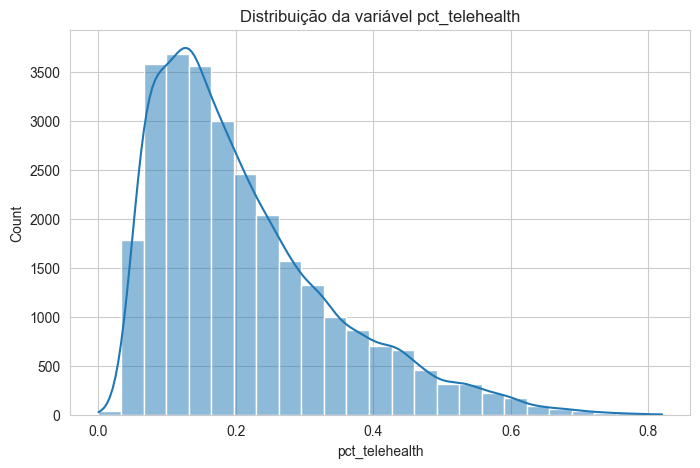

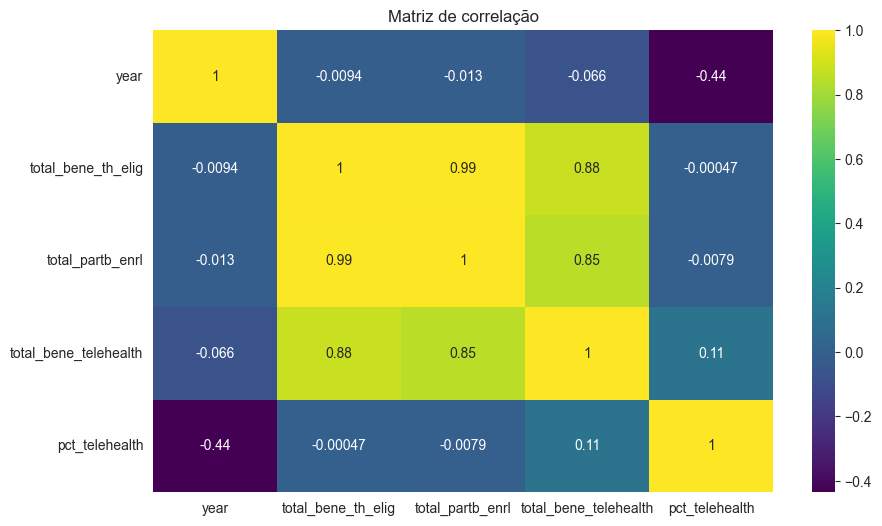


Distribuição de classes (High Adoption):
high_adoption
0    24317
1     6987
Name: count, dtype: int64

ACURÁCIA DO MODELO: 0.9008145663632008

RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4864
           1       0.82      0.71      0.76      1397

    accuracy                           0.90      6261
   macro avg       0.87      0.83      0.85      6261
weighted avg       0.90      0.90      0.90      6261


MATRIZ DE CONFUSÃO:
[[4647  217]
 [ 404  993]]


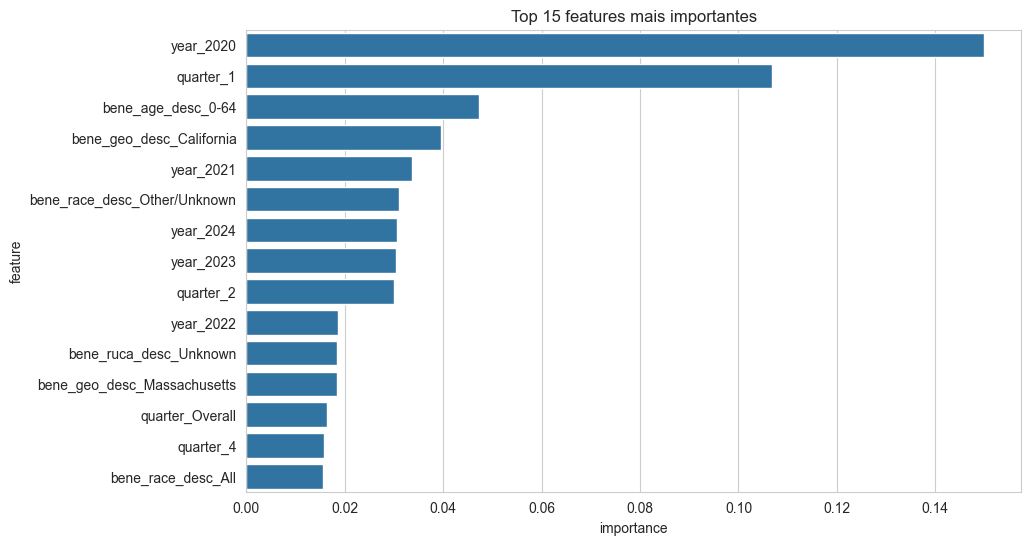

In [13]:
# =====================================
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# =====================================
# 2. CARREGAR DADOS
# =====================================
df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")
print("Primeiras linhas do dataset:")
print(df.head())

# =====================================
# 3. TRATAMENTO DE COLUNAS
# =====================================
df.columns = df.columns.str.strip()       # Remove espaços
df.columns = df.columns.str.lower()       # Deixa tudo minúsculo
print("\nColunas disponíveis:", df.columns)

# =====================================
# 4. ANÁLISE EXPLORATÓRIA (EDA)
# =====================================
# Distribuição do Pct_Telehealth
plt.figure(figsize=(8,5))
sns.histplot(df['pct_telehealth'], bins=25, kde=True)  # COLUNA CORRETA
plt.title("Distribuição da variável pct_telehealth")
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title("Matriz de correlação")
plt.show()

# =====================================
# 5. CRIAR CLASSE BINÁRIA (ALTO x BAIXO USO)
#    Top 25% de pct_telehealth por trimestre (quarter) = 1
# =====================================
df['high_adoption'] = 0
for q in df['quarter'].unique():
    mask = df['quarter'] == q
    cutoff = df.loc[mask, 'pct_telehealth'].quantile(0.75)
    df.loc[mask & (df['pct_telehealth'] >= cutoff), 'high_adoption'] = 1

print("\nDistribuição de classes (High Adoption):")
print(df['high_adoption'].value_counts())

# =====================================
# 6. SEPARAÇÃO FEATURES x TARGET
# =====================================
X = df[
    ['year', 'quarter', 'bene_geo_desc', 'bene_race_desc',
     'bene_sex_desc', 'bene_age_desc', 'bene_ruca_desc']
]
y = df['high_adoption']

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# =====================================
# 7. PRÉ-PROCESSAMENTO + MODELO
# =====================================
categorical_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', model)
])

# =====================================
# 8. TREINAR MODELO
# =====================================
clf.fit(X_train, y_train)

# =====================================
# 9. AVALIAÇÃO DO MODELO
# =====================================
y_pred = clf.predict(X_test)

print("\nACURÁCIA DO MODELO:", accuracy_score(y_test, y_pred))
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred))

print("\nMATRIZ DE CONFUSÃO:")
print(confusion_matrix(y_test, y_pred))

# =====================================
# 10. IMPORTÂNCIA DAS VARIÁVEIS
# =====================================
model_rf = clf.named_steps['model']
ohe = clf.named_steps['preprocess'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_features)
importances = model_rf.feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Top 15 features mais importantes")
plt.show()
